In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = './'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os

caffe.set_mode_cpu()
net = caffe.Classifier(caffe_root + 'object_pose_recognition/model/deploy.prototxt',
                caffe_root + 'object_pose_recognition/model/obe_clean_iter_2000.caffemodel',
                caffe.TEST)

blob = caffe.proto.caffe_pb2.BlobProto()
data = open( caffe_root + 'object_pose_recognition/model/obe_clean_mean.binaryproto' , 'rb' ).read()
blob.ParseFromString(data)
arr = np.array( caffe.io.blobproto_to_array(blob) )
meanPyc = arr[0]

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
def applyPreprocess(img):
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', meanPyc.mean(1).mean(1)) # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_input_scale('data', 255)
    net.blobs['data'].data[...] = transformer.preprocess('data', img)

net.blobs['data'].reshape(1,3,64,64)
img = caffe.io.load_image(caffe_root + 'object_pose_recognition/model/duck1.png')
applyPreprocess(img)
out = net.forward()
    
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

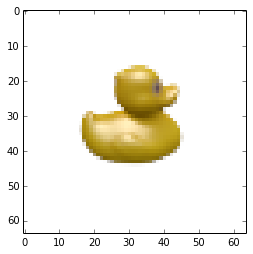

In [10]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

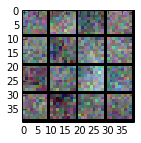

In [11]:
filters = net.params['conv1'][0].data
plt.rcParams['figure.figsize'] = (2, 2)
vis_square(filters.transpose(0, 2, 3, 1))

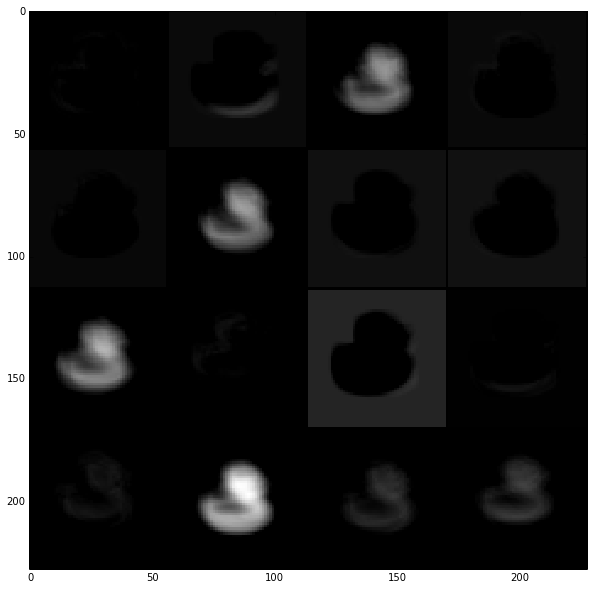

In [12]:
feat = net.blobs['conv1_a'].data[0]
plt.rcParams['figure.figsize'] = (10, 10)
vis_square(feat)

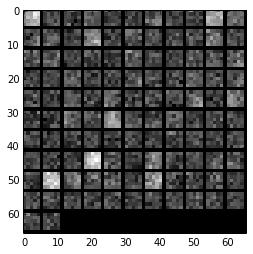

In [13]:
filters = net.params['conv2'][0].data
plt.rcParams['figure.figsize'] = (4, 4)
vis_square(filters.reshape(112, 5, 5))

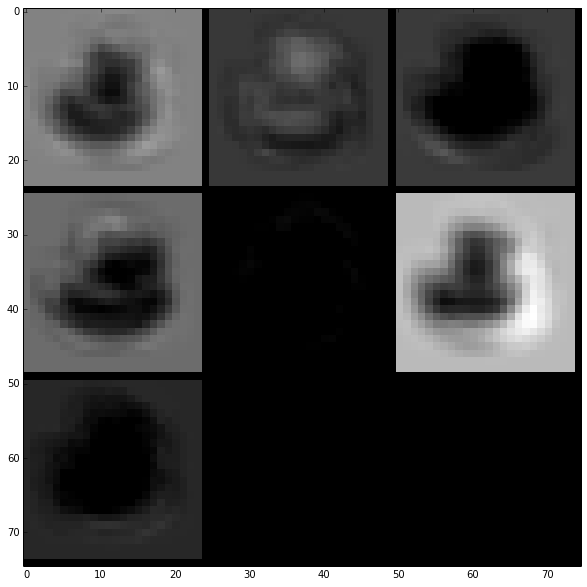

In [14]:
feat = net.blobs['conv2_a'].data[0, :36]
plt.rcParams['figure.figsize'] = (10, 10)
vis_square(feat)

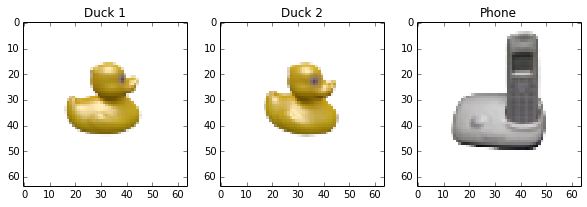

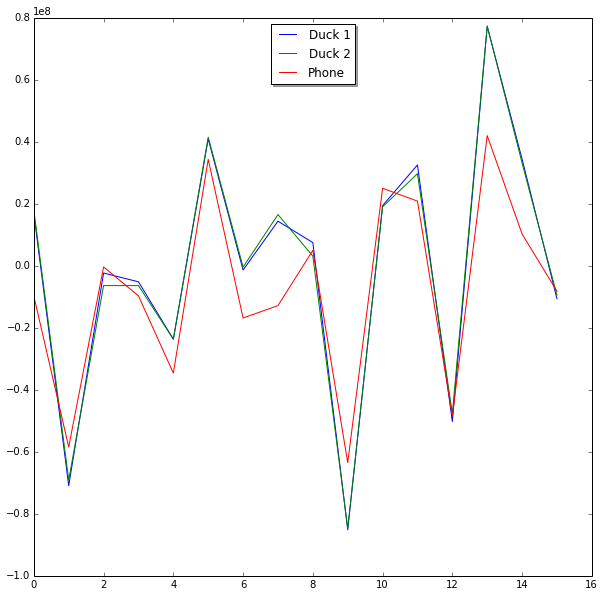

In [15]:
plt.rcParams['figure.figsize'] = (10, 10)

images = plt.figure()
fig, graph = plt.subplots()

img = caffe.io.load_image(caffe_root + 'object_pose_recognition/model/duck1.png')
applyPreprocess(img)
net.blobs['data'].data[...] = transformer.preprocess('data', img) 
out = net.forward()
data1 = np.transpose(out['ip4_a'])
graph.plot(data1, label='Duck 1')
img1 = transformer.deprocess('data', net.blobs['data'].data[0])
a = images.add_subplot(1,3,1)
a.set_title('Duck 1')
a.imshow(img1)

img = caffe.io.load_image(caffe_root + 'object_pose_recognition/model/duck2.png')
applyPreprocess(img)
out = net.forward()
data2 = np.transpose(out['ip4_a'])
graph.plot(data2, label='Duck 2')
img2 = transformer.deprocess('data', net.blobs['data'].data[0])
b = images.add_subplot(1,3,2)
b.set_title('Duck 2')
b.imshow(img2)

img = caffe.io.load_image(caffe_root + 'object_pose_recognition/model/phone.png')
applyPreprocess(img)
out = net.forward()
data3 = np.transpose(out['ip4_a'])
graph.plot(data3, label='Phone')
img3 = transformer.deprocess('data', net.blobs['data'].data[0])
c = images.add_subplot(1,3,3)
c.set_title('Phone')
c.imshow(img3)

legend = graph.legend(loc='upper center', shadow=True)